In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import pandas as pd
import sys
sys.path.append('./../../p-det-O3/')
from p_det_O3.emulator import *
sys.path.append("./../code/")
from training_routines import *
from draw_new_injections import draw_new_injections
import pickle
import tqdm
from figure_utilities import *

np.random.seed(230529)

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_27_weights.hdf5",
                scaler="./../data/trained_networks/job_27_input_scaler.pickle")

jitted_ann = jax.jit(ann)

In [5]:
injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i],neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


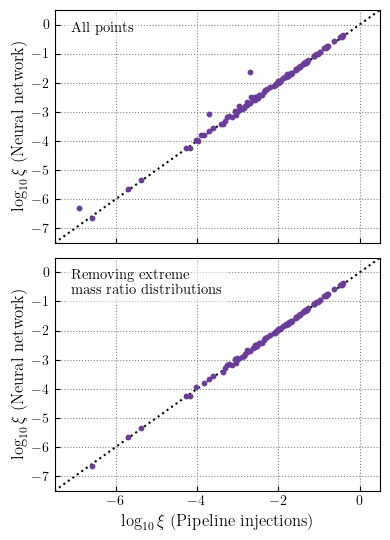

In [6]:
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs),np.log10(nn_effs_hybrid),marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'All points',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xticklabels([])
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

ax = fig.add_subplot(212)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs)[bqs>-3],np.log10(nn_effs_hybrid)[bqs>-3],marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'Removing extreme \n mass ratio distributions',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

plt.tight_layout()
plt.savefig('figure_06.pdf',bbox_inches='tight')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


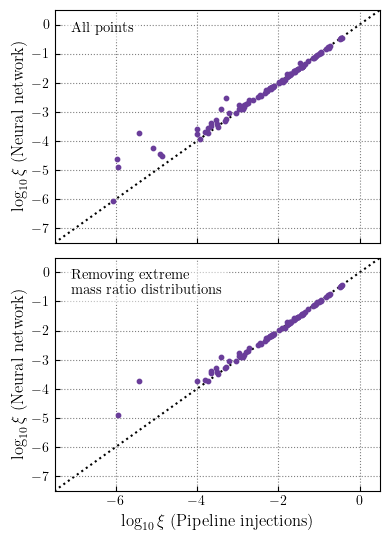

In [12]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_67_weights.hdf5",
                scaler="./../data/trained_networks/job_67_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i],neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

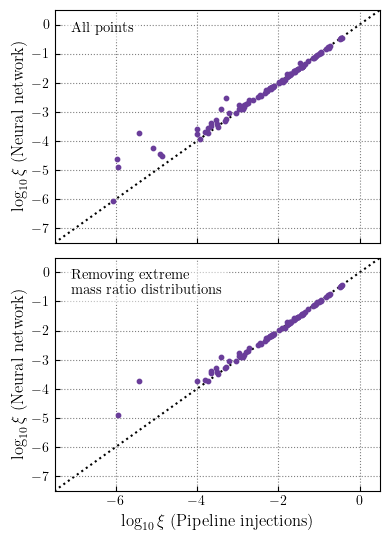

In [13]:
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs),np.log10(nn_effs_hybrid),marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'All points',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xticklabels([])
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

ax = fig.add_subplot(212)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs)[bqs>-3],np.log10(nn_effs_hybrid)[bqs>-3],marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'Removing extreme \n mass ratio distributions',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

plt.tight_layout()
plt.savefig('figure_06_altNetwork_67.pdf',bbox_inches='tight')
plt.show()

In [14]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_03_weights.hdf5",
                scaler="./../data/trained_networks/job_03_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i],neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


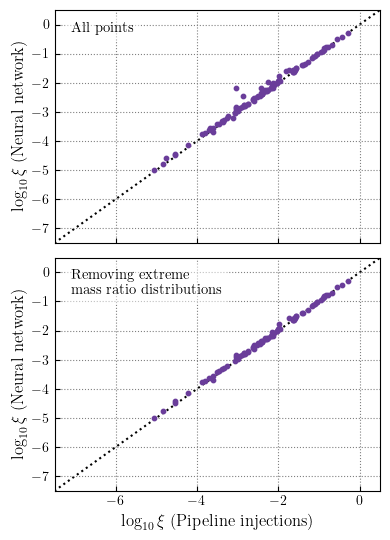

In [15]:
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs),np.log10(nn_effs_hybrid),marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'All points',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xticklabels([])
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

ax = fig.add_subplot(212)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs)[bqs>-3],np.log10(nn_effs_hybrid)[bqs>-3],marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'Removing extreme \n mass ratio distributions',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

plt.tight_layout()
plt.savefig('figure_06_altNetwork_03.pdf',bbox_inches='tight')
plt.show()

In [16]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_28_weights.hdf5",
                scaler="./../data/trained_networks/job_28_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i],neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


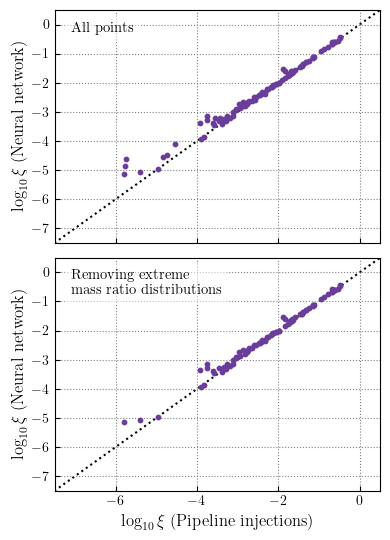

In [17]:
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs),np.log10(nn_effs_hybrid),marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'All points',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xticklabels([])
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

ax = fig.add_subplot(212)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs)[bqs>-3],np.log10(nn_effs_hybrid)[bqs>-3],marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'Removing extreme \n mass ratio distributions',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

plt.tight_layout()
plt.savefig('figure_06_altNetwork_28.pdf',bbox_inches='tight')
plt.show()

In [18]:
ann = p_det_O3(model_weights="./../data/trained_networks/job_17_weights.hdf5",
                scaler="./../data/trained_networks/job_17_input_scaler.pickle")
jitted_ann = jax.jit(ann)

injectionData = draw_vals(100000)

n = 100
inj_effs = np.zeros(n)
nn_effs_hybrid = np.zeros(n)
neff_inj = np.zeros(n)
neff_nn_hybrid = np.zeros(n)

alphas = np.random.normal(loc=-2,scale=3,size=n)
kappas = np.random.normal(loc=0,scale=5,size=n)
mu_m1 = np.random.uniform(20,50,size=n)
sig_m1 = np.random.uniform(2,15,size=n)
log_f_peaks = np.random.uniform(-6,0,size=n)
mMaxs = np.random.uniform(50,100,size=n)
mMins = np.random.uniform(5,15,size=n)
log_dmMaxs = np.random.uniform(0.5,1.5,size=n)
log_dmMins = np.random.uniform(-1,1,size=n)
bqs = np.random.normal(loc=0,scale=3,size=n)
mu_chis = np.random.random(size=n)
logsig_chis = np.random.uniform(-1,0,size=n)
f_isos = np.random.random(size=n)
mu_costs = np.random.uniform(-1,1,size=n)
sig_costs = np.random.uniform(0.15,2.5,size=n)

for i in tqdm.tqdm(range(n)):
    
    inj_effs[i],neff_inj[i] = get_inj_efficiency(
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i])
    
    nn_effs_hybrid[i],neff_nn_hybrid[i] = get_nn_efficiency(
                                    jitted_ann,
                                    injectionData,
                                    alphas[i],
                                    mu_m1[i],
                                    sig_m1[i],
                                    log_f_peaks[i],
                                    mMaxs[i],
                                    mMins[i],
                                    log_dmMaxs[i],
                                    log_dmMins[i],
                                    bqs[i],
                                    mu_chis[i],
                                    logsig_chis[i],
                                    f_isos[i],
                                    mu_costs[i],
                                    sig_costs[i],
                                    kappas[i],
                                    hybrid=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


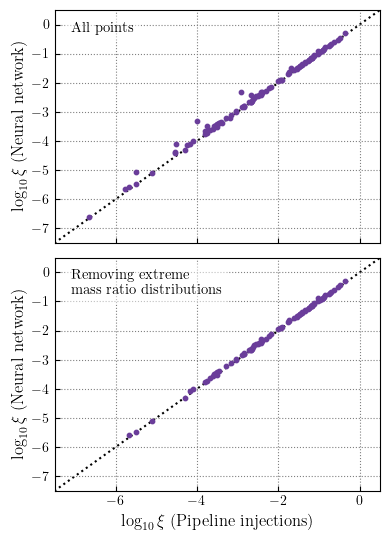

In [19]:
fig = plt.figure(figsize=(4,5.5))

ax = fig.add_subplot(211)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs),np.log10(nn_effs_hybrid),marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'All points',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xticklabels([])
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

ax = fig.add_subplot(212)
ax.plot([-8.5,0.5],[-8.5,0.5],ls=':',color='black',zorder=1)
ax.scatter(np.log10(inj_effs)[bqs>-3],np.log10(nn_effs_hybrid)[bqs>-3],marker='o',s=10,color=cmisc,zorder=2)
ax.text(0.05,0.95,'Removing extreme \n mass ratio distributions',
        transform=ax.transAxes,va='top',ha='left',ma='left',fontsize=10.5,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=4.0, lw=0.5))
ax.set_xlabel(r'$\log_{10}\xi$ (Pipeline injections)')
ax.set_ylabel(r'$\log_{10}\xi$ (Neural network)')
ax.set_xlim(-7.5,0.5)
ax.set_ylim(-7.5,0.5)

plt.tight_layout()
plt.savefig('figure_06_altNetwork_17.pdf',bbox_inches='tight')
plt.show()